In [8]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 0) Paths
MATRIX_HIGH_VAR = "data/processed/country_index_matrix_HIGH_VARIANCE.csv"
MATRIX_MEDIAN   = "data/processed/country_index_matrix_median.csv"

OUT_DIR = "data/processed/clustering"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load matrix
if os.path.exists(MATRIX_HIGH_VAR):
    df = pd.read_csv(MATRIX_HIGH_VAR)
    print("Loaded:", MATRIX_HIGH_VAR)
elif os.path.exists(MATRIX_MEDIAN):
    df = pd.read_csv(MATRIX_MEDIAN)
    print("Loaded:", MATRIX_MEDIAN)
else:
    raise FileNotFoundError(
        "Could not find a country index matrix. "
        "Run index_generation.ipynb first to create:\n"
        f"- {MATRIX_MEDIAN}\n- {MATRIX_HIGH_VAR}"
    )

# Drop obvious non-feature columns if they exist
META = {"Country", "date", "year", "window", "window_id"}
drop_cols = [c for c in ["date"] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

assert "Country" in df.columns, "Your matrix must have a 'Country' column."

# Build feature list (exclude common meta columns)
feature_cols = [c for c in df.columns if c not in META]

# One row per Country (country-level clustering)
if df["Country"].duplicated().any():
    df = (
        df.groupby("Country")[feature_cols]
            .median()
            .reset_index()
    )
    print("Collapsed to country-level matrix:", df.shape)
else:
    print("Already country-level:", df.shape)

feature_cols = [c for c in df.columns if c != "Country"]

# Build X (numeric only) + missing handling
X_raw = df[feature_cols].apply(pd.to_numeric, errors="coerce")
X = X_raw.fillna(X_raw.median(numeric_only=True))

print("Matrix shape:", X.shape, "(countries x features)")
print("Feature count:", len(feature_cols))
print("Unique countries:", df["Country"].nunique(), "Rows:", len(df))

Loaded: data/processed/country_index_matrix_HIGH_VARIANCE.csv
Collapsed to country-level matrix: (70, 31)
Matrix shape: (70, 30) (countries x features)
Feature count: 30
Unique countries: 70 Rows: 70


In [9]:
# 2) Scaling
SCALE_PROTECTION = True  # RobustScaler, more robust against outliers, I recommend
scaler = RobustScaler() if SCALE_PROTECTION else StandardScaler()

# NaN check and safe filling
nan_before = X_raw.isna().sum().sum()
print(f"Total NaN value (raw): {nan_before}")

if nan_before > 0:
    # First try to fill column-wise median
    X_filled = X_raw.fillna(X_raw.median(numeric_only=True))
    
    # If still NaN remains (all columns NaN), fill with 0
    nan_after_median = X_filled.isna().sum().sum()
    if nan_after_median > 0:
        print(f"{nan_after_median} NaN could not be filled with median → Filling with 0")
        X_filled = X_filled.fillna(0)
    
    X = X_filled
    print(f"All NaN have been cleaned. Current state: {X.isna().sum().sum()} NaN")
else:
    X = X_raw
    print("No NaN found, data is clean.")

# Scaling
X_scaled = scaler.fit_transform(X)
print(f"Scaling done: {X_scaled.shape} (RobustScaler: {SCALE_PROTECTION})")

# 3) Optional PCA
PCA_USE = True
PCA_PERCENTAGE = 0.90  # %90 variance retention

if PCA_USE:
    pca = PCA(n_components=PCA_PERCENTAGE, random_state=42)
    X_model = pca.fit_transform(X_scaled)
    explained = np.sum(pca.explained_variance_ratio_)
    print(f"PCA applied: {X_model.shape[1]} components")
    print(f"Explained variance ratio: {explained:.3f}")
else:
    X_model = X_scaled
    explained = 1.0
    print("PCA skipped, scaled data directly used.")

Total NaN value (raw): 70
70 NaN could not be filled with median → Filling with 0
All NaN have been cleaned. Current state: 0 NaN
Scaling done: (70, 30) (RobustScaler: True)
PCA applied: 4 components
Explained variance ratio: 0.904


In [10]:
# 6) Hierarchical clustering
RUN_HIERARCHICAL = True
if RUN_HIERARCHICAL:
    agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
    labels_ag = agg.fit_predict(X_model)
    df_out["cluster_agglo"] = labels_ag
    df_out.to_csv(os.path.join(OUT_DIR, "country_clusters_kmeans_plus_agglo.csv"), index=False)



In [11]:
# 7) Interpretation: what defines each cluster?
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
X_scaled_df["Country"] = df["Country"].values
X_scaled_df["cluster"] = labels_km

cluster_profiles = X_scaled_df.groupby("cluster")[feature_cols].mean()

TOP_N = 8
summary_rows = []
for cl in cluster_profiles.index:
    s = cluster_profiles.loc[cl].sort_values(ascending=False)
    top_pos = s.head(TOP_N)
    top_neg = s.tail(TOP_N)

    summary_rows.append({
        "cluster": cl,
        "top_positive_features": ", ".join([f"{i} ({v:.2f})" for i, v in top_pos.items()]),
        "top_negative_features": ", ".join([f"{i} ({v:.2f})" for i, v in top_neg.items()]),
        "n_countries": int((labels_km == cl).sum())
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values("cluster")
display(cluster_summary)

cluster_profiles.to_csv(os.path.join(OUT_DIR, "cluster_profiles_zscores.csv"))
cluster_summary.to_csv(os.path.join(OUT_DIR, "cluster_summary_top_features.csv"), index=False)

countries_per_cluster = (
    df_out.groupby("cluster_kmeans")["Country"]
    .apply(list)
    .reset_index(name="countries")
)
display(countries_per_cluster)
countries_per_cluster.to_json(
    os.path.join(OUT_DIR, "countries_per_cluster.json"),
    orient="records",
    indent=2
)


,cluster,top_positive_features,top_negative_features,n_countries
0,0,"tech_security_privacy_index (1.74), crime_gun_...","crime_cybercrime_index (-0.10), social_vegan_l...",63
1,1,"health_healthcare_access_index (20.68), tech_s...","health_mental_health_index (0.09), crime_viole...",7


,cluster_kmeans,countries
0,0,"[AE, AR, AT, AU, BD, BE, BG, BO, BR, CA, CH, C..."
1,1,"[GB, IN, JP, KR, MX, TR, US]"


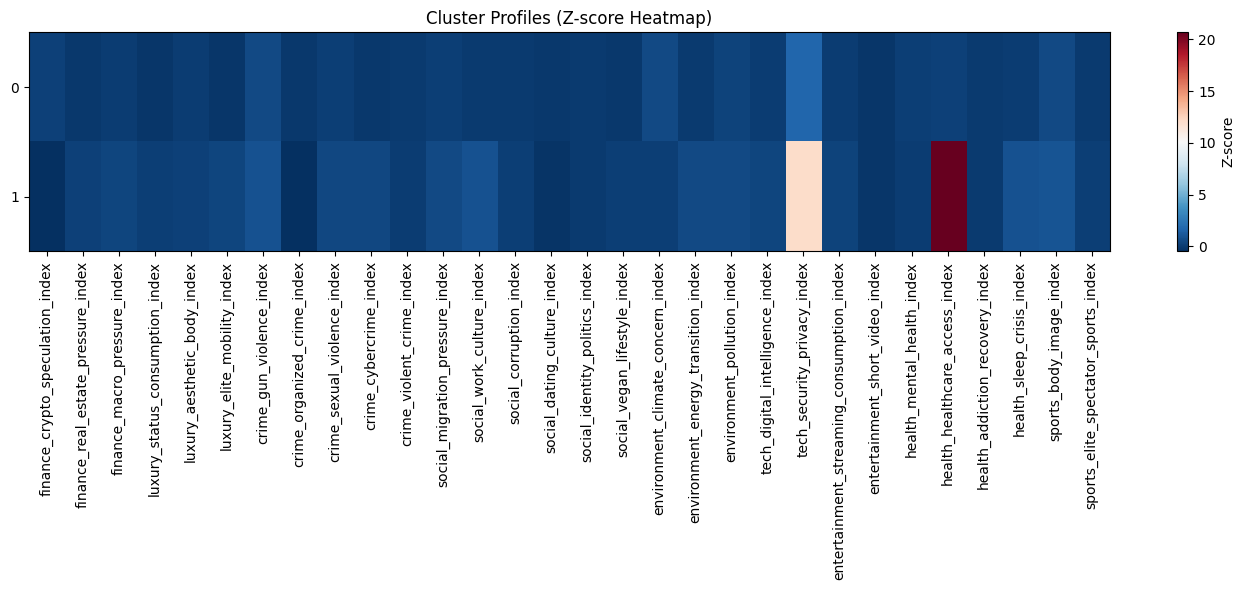

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

profiles = pd.read_csv("data/processed/clustering/cluster_profiles_zscores.csv", index_col=0)

plt.figure(figsize=(14,6))
plt.imshow(profiles, aspect="auto",cmap="RdBu_r")
plt.colorbar(label="Z-score")
plt.xticks(range(len(profiles.columns)), profiles.columns, rotation=90)
plt.yticks(range(len(profiles.index)), profiles.index)
plt.title("Cluster Profiles (Z-score Heatmap)")
plt.tight_layout()
plt.show()


## Cluster Profiles Heatmap – Key Insights

- The heatmap displays **z-score–normalized trend indices** for two clusters (**Cluster 0** and **Cluster 1**).

- **Cluster 0 (top row):**
  - Most feature values are **close to zero**, indicating
    **balanced and moderate interest** across all topic categories.
  - No single topic strongly dominates the cluster profile.

- **Cluster 1 (bottom row):**
  - Characterized by **extreme values in a small number of features**.
  - **Highest positive (red):**
    - Health access index (**≈ +20**) – extremely strong emphasis
    - Digital privacy & security index (**≈ +12**) – very strong concern
  - **Highest negative (dark blue):**
    - Short-video entertainment – very low interest
    - Organized crime – minimal relative focus

- **Overall interpretation:**
  - **Cluster 1** countries exhibit a **specialized, high-intensity focus** on
    healthcare systems and digital security.
  - **Cluster 0** countries display a **neutral, diversified trend structure**,
    with no dominant thematic emphasis.


<Axes: >

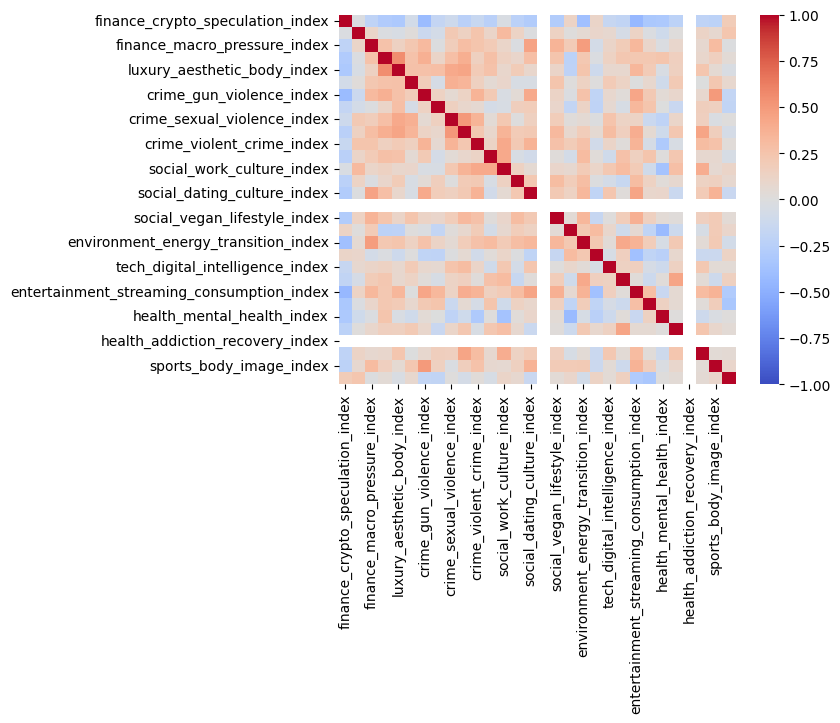

In [13]:
# Correlation matrix kontrol
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='coolwarm')
# If there is a correlation greater than 0.8, merge the features